In [133]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # ploting graphs and chart 
from datetime import timedelta # for time formatting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-official-movies-dataset/title-ratings.tsv
/kaggle/input/imdb-official-movies-dataset/title-metadata.tsv
/kaggle/input/imdb-official-movies-dataset/title-crew.tsv


In [134]:
df = pd.read_table('/kaggle/input/imdb-official-movies-dataset/title-ratings.tsv', low_memory=False)
df2 = pd.read_table('/kaggle/input/imdb-official-movies-dataset/title-metadata.tsv',low_memory=False)

In [135]:
# Merging Rating and MetaData datsets into single dataframe w.r.t common column
main_df = pd.merge(df,df2,on='tconst')
main_df.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.7,1914,short,Carmencita,Carmencita,0,1894,\N,1,\N
1,tt0000002,5.8,259,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,\N
2,tt0000003,6.5,1720,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,\N
3,tt0000004,5.6,172,short,Un bon bock,Un bon bock,0,1892,\N,12,\N
4,tt0000005,6.2,2537,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,\N


**DATA Cleaning:**

In [136]:
# creating a copy 
imdb_df = main_df.copy()

**Currently, 'runtimeMinutes' column is in Minutes form thus we will convert it into Days:HH:MM:SS Format for better display of runtime information**

In [137]:
imdb_df['runtimeMinutes'].value_counts()

\N      358359
30       42810
60       37284
22       36831
90       28662
         ...  
567          1
3900         1
2150         1
1620         1
468          1
Name: runtimeMinutes, Length: 707, dtype: int64

In [138]:
# Replace object type string '\N' with NaN First
imdb_df['runtime_delta'] = pd.to_numeric(imdb_df['runtimeMinutes'], errors='coerce', downcast="integer")

In [139]:
# Using 'pd.to_timedelta' to convert minutes into desired format
imdb_df['runtime_delta'] = pd.to_timedelta(imdb_df['runtime_delta'], unit='m')

**Similarly, The 'isAdult' column should contain only two values, '0: non-adult title, 1: adult title' but here As we can see dataFrame column consist of mixed data values like string, bool and int. Thus, Lets sort and restructure this column into a Bool data type.**

In [140]:
imdb_df['isAdult'].unique()

array(['0', '1', '2020', '2014'], dtype=object)

In [141]:
# Replace string and int by boolean
# we will leave out '2014' and '2020' as it is as there`s no way to confirm If they Adult or not not
imdb_df['isAdult'] = imdb_df['isAdult'].map({'0': 'Non_Adult_Title', '1': 'Adult_Title'})

In [142]:
imdb_df.isAdult = imdb_df.isAdult.fillna('Unrated')
imdb_df['isAdult'].unique()

array(['Non_Adult_Title', 'Adult_Title', 'Unrated'], dtype=object)

**Creating a new column to provide information of show run timeline in better way by joinning 'startYear' and 'endYear' columns into one**

In [143]:
# First, we should replace '\N' values to nan so next step
imdb_df['startYear'] = imdb_df['startYear'].replace('\\N', np.NaN)
imdb_df['endYear'] = imdb_df['endYear'].replace('\\N', np.NaN)

In [144]:
# Now joinning them  
imdb_df['premiere_timeline'] = imdb_df[['startYear','endYear']].stack().groupby(level=0).agg('-'.join)

**The data cleaning has been completed. However, Lets drop unneccessory columns from this dataframe for furthur analysis:**

In [145]:
# Drop unneccessory columns from dataframe
columns_to_keep = ['tconst','averageRating','numVotes','titleType','primaryTitle',
                   'isAdult','premiere_timeline','runtime_delta']

imdb_df = imdb_df[columns_to_keep]

# Also renaming them with approriate name
renamed_cols = {'tconst':'IMDB_ID','averageRating':'Avg_Rating','numVotes':'Total_Votes',
                'titleType':'Title_Category','primaryTitle':'Title_Name','isAdult':'IN-18+'
                ,'premiere_timeline':'Air_time','runtime_delta':'Title_Runtime_Length'}

imdb_df.rename(columns = renamed_cols,inplace=True)
imdb_df.head()

,IMDB_ID,Avg_Rating,Total_Votes,Title_Category,Title_Name,IN-18+,Air_time,Title_Runtime_Length
0,tt0000001,5.7,1914,short,Carmencita,Non_Adult_Title,1894,0 days 00:01:00
1,tt0000002,5.8,259,short,Le clown et ses chiens,Non_Adult_Title,1892,0 days 00:05:00
2,tt0000003,6.5,1720,short,Pauvre Pierrot,Non_Adult_Title,1892,0 days 00:04:00
3,tt0000004,5.6,172,short,Un bon bock,Non_Adult_Title,1892,0 days 00:12:00
4,tt0000005,6.2,2537,short,Blacksmith Scene,Non_Adult_Title,1893,0 days 00:01:00


**Top 10 highest voted and rated Titles across all categories**

In [146]:
top_10_highest = imdb_df.groupby(['Title_Name'])[
    ['Avg_Rating','Total_Votes']].max().sort_values(by=['Avg_Rating','Total_Votes'
                                                       ], ascending = False).reset_index().head(10)

top_10_highest

,Title_Name,Avg_Rating,Total_Votes
0,Fight Club,10.0,2091999
1,Gladiator,10.0,1483822
2,Die Hard,10.0,869876
3,Ratatouille,10.0,727214
4,Limitless,10.0,570901
5,Shaun of the Dead,10.0,555530
6,Lost,10.0,549336
7,Fury,10.0,485732
8,Tangled,10.0,450335
9,Vertigo,10.0,400388


**Many Many other titles received the Perfect Rating of 10 across all Category but My personal favorite movie of all time, 'Fight Club' tops the table with Perfect Rating and highest Individual votes received while 'Gladiator' and 'Die Hard' takes the 2nd and 3rd spot respectivly on IMDB table.**

**Average votes and rating given to all categories**

In [147]:
highest_rated_type = imdb_df.groupby(['Title_Category'])[['Avg_Rating','Total_Votes']].mean(
).sort_values(by=['Avg_Rating','Total_Votes'], ascending = False).reset_index().round(decimals = 1)

highest_rated_type

,Title_Category,Avg_Rating,Total_Votes
0,tvEpisode,7.4,185.3
1,tvMiniSeries,7.1,1147.3
2,videoGame,6.9,357.4
3,tvShort,6.9,200.6
4,tvSeries,6.9,1423.6
5,short,6.8,72.4
6,tvSpecial,6.8,212.7
7,tvMovie,6.6,233.2
8,video,6.6,192.6
9,movie,6.2,3532.7


**Seems like 'tvEpisode' Category has received the best avg. Rating of 7.4/title when compaired to all other title types but received very less avg. votes per title. On the other hand, 'Movie' Category tops the chart as they received highest 3532.7 votes/titles on IMDB.**

**Category_wise longest running titles as per IMDB_database**

In [148]:
longest_runtime = imdb_df.loc[imdb_df.groupby(['Title_Category'], 
                                              sort=False)['Title_Runtime_Length'].idxmax()
                             ][['Title_Category', 'Title_Name', 'Title_Runtime_Length']]

longest_runtime.sort_values(by='Title_Runtime_Length', ascending = False).reset_index(drop=True)

,Title_Category,Title_Name,Title_Runtime_Length
0,movie,Logistics,35 days 17:00:00
1,video,The Longest Video on YouTube: 596.5 Hours,24 days 20:31:00
2,tvSpecial,Svalbard Minute by Minute,9 days 05:59:00
3,videoGame,Big Chungus,5 days 09:37:00
4,tvSeries,Great Chefs of the World,3 days 08:00:00
5,tvEpisode,The George Lucas Talk Show May the 4th Marathon,1 days 06:45:00
6,tvMiniSeries,War and Remembrance,1 days 03:00:00
7,tvMovie,24 Hours Berlin,1 days 00:00:00
8,short,Transsexuals from Space,0 days 01:53:00
9,tvShort,Prideland,0 days 00:55:00


**In our analysis, Movie named 'Logistics' has the longest run-time across all categories, at 35 Days and 17 Hours. While, 'The Longest Video on YouTube: 596.5 Hours' is in the second place.**

**Now, Lets check Category_wise shortest running titles as per IMDB_database**

In [149]:
shortest_runtime = imdb_df.loc[imdb_df.groupby(['Title_Category'], 
                                              sort=False)['Title_Runtime_Length'].idxmin()
                             ][['Title_Category', 'Title_Name', 'Title_Runtime_Length']]

shortest_runtime.reset_index(drop=True)

,Title_Category,Title_Name,Title_Runtime_Length
0,short,Awakening of Rip,0 days 00:00:00
1,movie,Fair at Ljutomer,0 days 00:01:00
2,tvEpisode,The Partridge Family,0 days 00:01:00
3,tvSeries,Beastly Behaviour,0 days 00:01:00
4,tvShort,The FA Cup Promotion,0 days 00:01:00
5,tvMovie,Das Bernstein-Amulett,0 days 00:02:00
6,tvMiniSeries,Loona TV,0 days 00:01:00
7,tvSpecial,Daisy,0 days 00:01:00
8,video,Sneeuwwitje,0 days 00:01:00
9,videoGame,Scud: The Disposable Assassin,0 days 00:02:00


**Short category film 'Awakening of Rip' holds the top place for being the shortest length title in IMDB_database.**

**Now, Lets shed some light on Average Ratings of Non_Adult Rated Titles vs Adult Rated Titles**

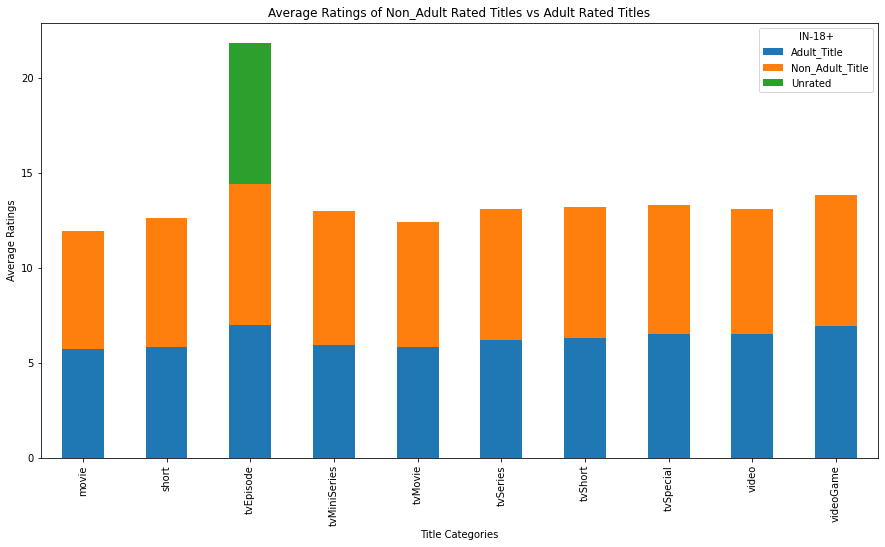

In [150]:
wanna_adult_or_not = imdb_df.groupby(['Title_Category','IN-18+']
                                    )['Avg_Rating'].agg('mean').round(1).unstack(fill_value= 0) 
wanna_adult_or_not.reset_index(inplace = True)
##### Visualise the chart in stack manner of bar type

plt.rcParams['figure.figsize'] = [15, 8]
wanna_adult_or_not.plot(x='Title_Category', kind='bar', stacked=True, 
                        title='Average Ratings of Non_Adult Rated Titles vs Adult Rated Titles')
plt.xlabel('Title Categories')
plt.ylabel('Average Ratings')
plt.show()

**'TvEpisode' category has received the highest Avg. Ratings in both Adult and Non-Adult rated title categories, However they there also the only title category among all whose some of the films/shows went Un-Rated.**

**Here ends this project, where we dig deep into the dataframe. First, We cleaned it and then sorted the data structure making a display of meaningful data. If you want to give any suggestion and point out mistakes please feel free to contact. Thanks!**